In [1]:
# downloading dataset from https://archive.materialscloud.org/record/2020.110

!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz
!gunzip -k methane.extxyz.gz

--2020-10-14 21:48:22--  https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528
Resolving archive.materialscloud.org (archive.materialscloud.org)... 148.187.96.41
Connecting to archive.materialscloud.org (archive.materialscloud.org)|148.187.96.41|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://object.cscs.ch/archive/b6/12/d8e3-58af-4374-96ba-b3551ac5d2f4/data?response-content-type=application%2Foctet-stream&response-content-disposition=attachment%3B%20filename%3Dmethane.extxyz.gz&Expires=1602704962&Signature=AD0Z4TuaW%2BM95bIgUSMQks6Vn7o%3D&AWSAccessKeyId=ee64314446074ed3ab5f375a522a4893 [following]
--2020-10-14 21:48:22--  https://object.cscs.ch/archive/b6/12/d8e3-58af-4374-96ba-b3551ac5d2f4/data?response-content-type=application%2Foctet-stream&response-content-disposition=attachment%3B%20filename%3Dmethane.extxyz.gz&Expires=1602704962&Signature=AD0Z4TuaW%2BM95bIgUSMQks

In [2]:
import numpy as np
import ase.io
import tqdm
from nice.blocks import *
from nice.utilities import *
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge

In [3]:
HARTREE_TO_EV = 27.211386245988
train_subset = "0:10000"  #input for ase.io.read command
test_subset = "10000:15000"  #input to ase.io.read command
environments_for_fitting = 1000  #number of environments to fit nice transfomers
grid = [150, 200, 350, 500, 750, 1000, 1500, 2000, 3000, 5000, 7500,
        10000]  #for learning curve

#HYPERS for librascal spherical expansion coefficients
HYPERS = {
    'interaction_cutoff': 6.3,
    'max_radial': 5,
    'max_angular': 5,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'
}

In [4]:
#our model:
def get_nice():
    return StandardSequence([
        StandardBlock(ThresholdExpansioner(num_expand=150),
                      CovariantsPurifierBoth(max_take=10),
                      IndividualLambdaPCAsBoth(n_components=50),
                      ThresholdExpansioner(num_expand=300, mode='invariants'),
                      InvariantsPurifier(max_take=50),
                      InvariantsPCA(n_components=200)),
        StandardBlock(ThresholdExpansioner(num_expand=150),
                      CovariantsPurifierBoth(max_take=10),
                      IndividualLambdaPCAsBoth(n_components=50),
                      ThresholdExpansioner(num_expand=300, mode='invariants'),
                      InvariantsPurifier(max_take=50),
                      InvariantsPCA(n_components=200)),
        StandardBlock(None, None, None,
                      ThresholdExpansioner(num_expand=300, mode='invariants'),
                      InvariantsPurifier(max_take=50),
                      InvariantsPCA(n_components=200))
    ],
                            initial_scaler=InitialScaler(
                                mode='signal integral', individually=True))

In [5]:
train_structures = ase.io.read('methane.extxyz', index=train_subset)

test_structures = ase.io.read('methane.extxyz', index=test_subset)

all_species = get_all_species(train_structures + test_structures)

train_coefficients = get_spherical_expansion(train_structures, HYPERS,
                                             all_species)

test_coefficients = get_spherical_expansion(test_structures, HYPERS,
                                            all_species)

100%|██████████| 2/2 [00:00<00:00, 81.88it/s]


In [6]:
#individual nice transformers for each atomic specie in the dataset
nice = {}
for key in train_coefficients.keys():
    nice[key] = get_nice()

In [7]:
for key in train_coefficients.keys():
    nice[key].fit(train_coefficients[key][:environments_for_fitting])

/home/pozdn/.local/lib/python3.6/site-packages/nice/blocks/compressors.py:218: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 200, desired number of environments is 2000, actual number of environments is 1000.
  self.n_components, num_fit_now, X.shape[0]))
/home/pozdn/.local/lib/python3.6/site-packages/nice/blocks/compressors.py:218: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 200, desired number of environments is 2000, actual number of environments is 1000.
  self.n_components, num_fit_now, X.shape[0]))
/home/pozdn/.local/lib/python3.6/site-packages/nice/blocks/compressors.py:218: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 200, desired number of environments is 2000, actual number of environments is 1000.
  self.n_components, num_fit_now, X.shape[0]))
/home/pozdn/.local/lib/python3.6/site-packages/nice/blocks/compr

In [8]:
train_features = transform_sequentially(nice, train_structures, HYPERS,
                                        all_species)
test_features = transform_sequentially(nice, test_structures, HYPERS,
                                       all_species)

100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


In [9]:
train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV

In [10]:
def get_rmse(first, second):
    return np.sqrt(np.mean((first - second)**2))


def get_standard_deviation(values):
    return np.sqrt(np.mean((values - np.mean(values))**2))


def get_relative_performance(predictions, values):
    return get_rmse(predictions, values) / get_standard_deviation(values)


def estimate_performance(regressor, data_train, data_test, targets_train,
                         targets_test):
    regressor.fit(data_train, targets_train)
    return get_relative_performance(regressor.predict(data_test), targets_test)

In [11]:
errors = []
for el in tqdm.tqdm(grid):
    errors.append(
        estimate_performance(BayesianRidge(), train_features[:el],
                             test_features, train_energies[:el],
                             test_energies))

100%|██████████| 12/12 [00:46<00:00,  3.89s/it]


In [12]:
print(errors)

[0.4247126794269763, 0.42805785746489716, 0.3497226396398819, 0.23190186163298276, 0.18079749193866107, 0.16262470945450516, 0.13101348407154506, 0.11636322521569345, 0.09869538918396933, 0.08353373821761646, 0.07244647819042843, 0.07013372099208232]


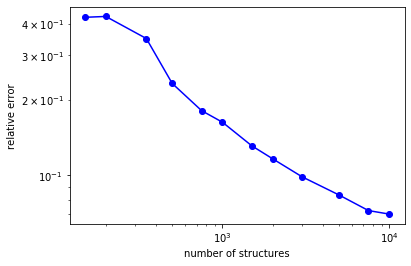

In [13]:
from matplotlib import pyplot as plt
plt.plot(grid, errors, 'bo')
plt.plot(grid, errors, 'b')
plt.xlabel("number of structures")
plt.ylabel("relative error")
plt.xscale('log')
plt.yscale('log')
plt.show()